In [288]:
from __init__ import *
from manifold_functions import *

In [298]:
input_animal = 'H0466'
input_session = 'I01' 
input_stage = 'CHO'

In [299]:
all_traces_dlc = pd.read_csv('/Users/rufusmitchell-heggs/Desktop/data_analysis/preprocessing/event_arena/'+input_animal+'/output_directory/'+input_animal+'_trace_dlc_LR.csv')

In [410]:
#Session and stage selection based on input
traces = all_traces_dlc[all_traces_dlc['Session']==input_session][all_traces_dlc[all_traces_dlc['Session']==input_session]['stage']==input_stage]
traces = traces.reset_index(drop=True)

all_info = all_traces_dlc[all_traces_dlc['Session']==input_session][all_traces_dlc[all_traces_dlc['Session']==input_session]['stage']==input_stage]

#Isolate neuronal time series and remove any NaN columns
raw_traces = traces[traces[[col for col in traces if col.startswith(' C')]]
            .loc[:,~(traces[[col for col in traces if col.startswith(' C')]]==" nan").any()]
            .columns.values]

cells = raw_traces.columns #Save cell identities
time = np.array(traces['Time (s)']) #Save time as a variable
behav_vec = np.array(all_info['position'])

/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [1313]:
# #Check through neuron time series and remove unlikely neurons
# num_cells_analysed = 0
# %matplotlib inline

# for cell in cells:

#     #Allow user to see how many cells they have looked through
#     num_cells_analysed +=1
#     num_cells_left = len(cells)-1
#     print(cell, num_cells_analysed,'/',num_cells_left)

#     #plot the raw traces and overlapping events
#     plt.figure(figsize=(8, 1), dpi=400)
#     plt.plot(raw_traces[str(cell)].astype(float), linewidth=0.5)
#     plt.show()

#     #Option to remove any bad cells
#     good_events = input("Are all events good - y/n?")
#     if good_events != 'y':
#         print(bcolors.FAIL+cell,'Dropped'+bcolors.ENDC)
#         raw_traces = raw_traces.drop([cell], axis=1)

#     else:
#         print(bcolors.OKGREEN+cell,'Accepted'+bcolors.ENDC)

# #Update cells being analysed list
# cells = raw_traces.columns[11:]

In [412]:
# Preprocess raw data
raw_traces_fixed = raw_traces #delete first few frames
raw_traces_fixed = raw_traces_fixed.apply(pd.to_numeric, errors='coerce')
raw_traces_fixed[raw_traces_fixed < 0] = 0 # Threshold at 0
traces_df = raw_traces_fixed.apply(lambda x: x/x.max(), axis=0) # normalize each cell by its max 
cells = traces_df.columns # reassign the cells that are being analysed

#Create array for analysis
traces =np.array(traces_df).transpose()

In [1314]:
# #Visualise all cell traces as final check
# from itertools import cycle
# cycol = cycle('bgrcmk')

# columns = 1
# rows = len(cells)
# fig, ax_array = plt.subplots(rows, columns, figsize=(100, 100), squeeze=False)
# for i,ax_row in enumerate(ax_array):
#     for j,axes in enumerate(ax_row):
#         axes.set_facecolor('xkcd:white')
#         axes.plot(traces_df[cells[i]].astype(float), c='k', linewidth=5)
#         axes.get_yaxis().set_ticks([])
#         axes.get_xaxis().set_visible(False)
#         axes.axis('off')

Text(0, 0.5, 'y coordinate (pixels)')

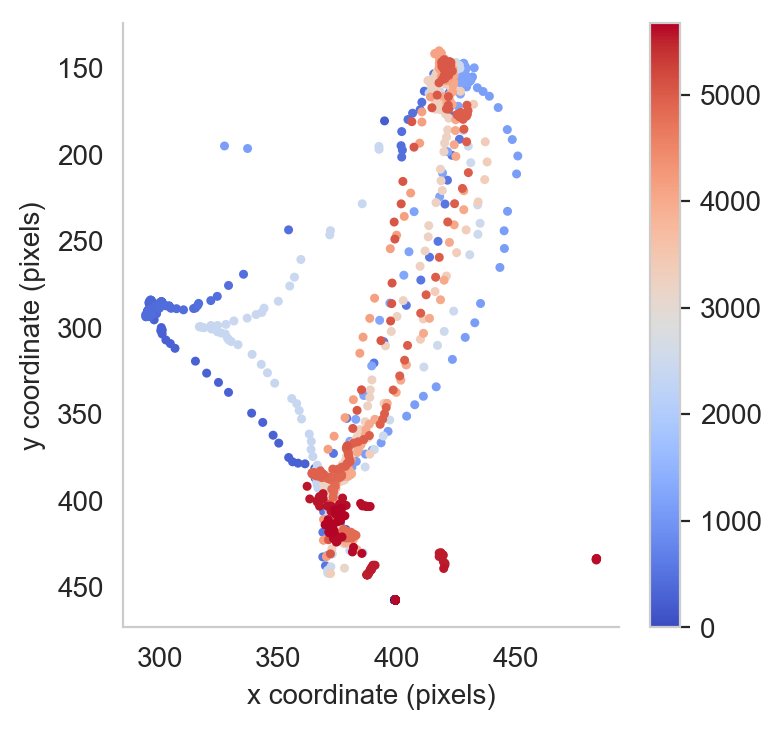

In [496]:
#Plot all trajectories
trace_dlc = all_info.iloc[int((list(all_info['door_frame'])[0])-(10/0.05006)):]
x = trace_dlc['x']
y = trace_dlc['y']

fig = plt.figure(num=None, figsize=(4,4), dpi=200, facecolor='w', edgecolor='k')
t = np.arange(0,len(y))
plt.scatter(x,y, s=5, c=t, cmap=cm.coolwarm)
plt.colorbar()
plt.gca().invert_yaxis()
sns.despine()
plt.grid(b=None)
plt.xlabel('x coordinate (pixels)')
plt.ylabel('y coordinate (pixels)')

In [1266]:
#Extract all individual trials by their temporal boundaries
time_before = 200 # Time included before trial start
time_after = 20 # Time included after trial start

#Initialise timestamps of startbox at trial start 
preplay_time_before = time_before #If preplay is considered can decrease
preplay_time_after = 0 #If preplay is considered can increase

# Extract trial vector
new_behav_vec = np.array(trace_dlc['position'])

#Extract trial outbound and inbound timestamps
outbound_start = []
inbound_end = []
door_opening = [] #label time when animal is in startbox at begining
for pos in range(len(trial_vec)):
    if 0 < pos < len(trial_vec):
        #Conditions use behaviour vector (defined in preprocessing)
        if trial_vec[pos] == 0 and trial_vec[pos-1] == 12 and (12 not in trial_vec[pos:pos+80]):
            outbound_start.append(pos-time_before)
            door_opening.append(np.arange(pos-preplay_time_before, pos+preplay_time_after, 1)) 

        elif trial_vec[pos] == 12 and trial_vec[pos-1] == 0 and (0 not in trial_vec[pos:pos+80]):
            inbound_end.append(pos+time_after)

door_opening = [item for sublist in door_opening for item in sublist]; new_behav_vec[door_opening] = 9
trials = [np.arange(outbound_start[i], inbound_end[i], 1) for i in range(len(inbound_end))]

Text(0.5, 0, 'Frames')

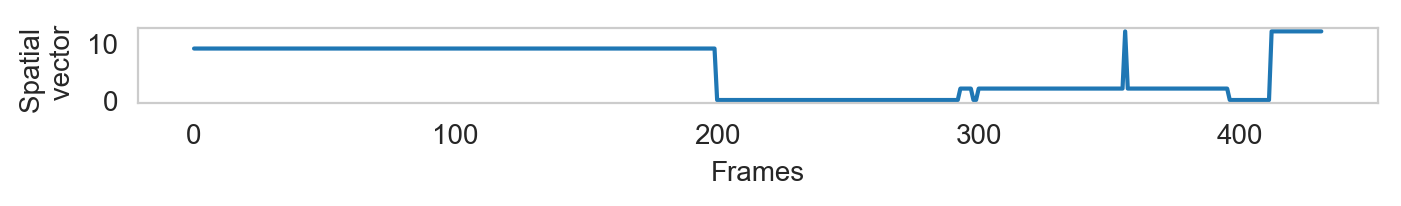

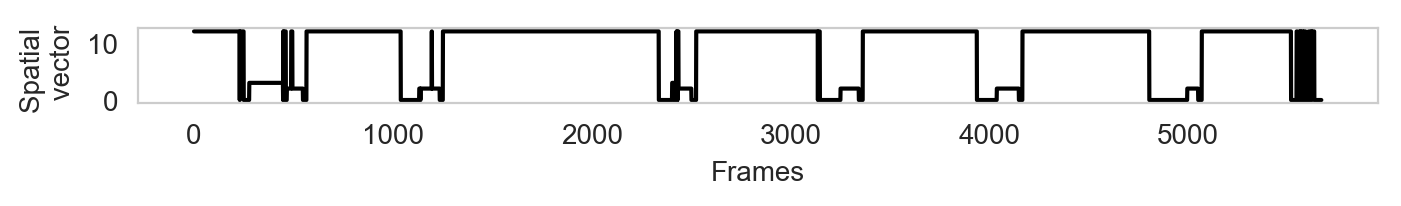

In [1280]:
#Check select trial position 
trial = 1
fig = plt.figure(num=None, figsize=(8,.5), dpi=200, facecolor='w', edgecolor='k')
plt.plot(np.arange(0,len(trials[trial]),1), new_behav_vec[outbound_start[trial]:inbound_end[trial]])
plt.grid(b=None)
plt.ylabel('Spatial \n vector')
plt.xlabel('Frames')

fig = plt.figure(num=None, figsize=(8,.5), dpi=200, facecolor='w', edgecolor='k')
plt.plot(np.arange(0,len(trace_dlc['position']),1),trace_dlc['position'], c='k')
plt.grid(b=None)
plt.ylabel('Spatial \n vector')
plt.xlabel('Frames')

<function matplotlib.pyplot.show(*args, **kw)>

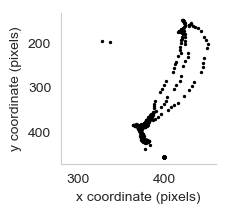

In [1286]:
correct_trials = [1,3,4,5] # Note of correct trials (by index)
all_correct_trials = [item for sublist in [trials[i] for i in range(len(trials)) if i in correct_trials] for item in sublist]

#Define variables
trial_trace = traces_df.loc[all_correct_trials] #Normalised raw traces for all correct trials
trial_behav_vec = new_behav_vec[all_correct_trials] #behav_vec for all correct trials
trial_x, trial_y = np.array(all_info['x'])[all_correct_trials], np.array(all_info['y'])[all_correct_trials]

#Can plot individual trials using variables below
# trial=5
# trial_trace = traces_df.loc[trials[trial]]
# trial_behav_vec = np.array(all_info['position'])[trials[trial]]
# trial_behav_vec = new_behav_vec[trials[trial]]
# trial_x, trial_y = np.array(all_info['x'])[trials[trial]], np.array(all_info['y'])[trials[trial]]

fig = plt.figure(num=None, figsize=(2,2), dpi=100, facecolor='w', edgecolor='k')
t = np.arange(0,len(trial_y))
plt.scatter(trial_x, trial_y, s=2, c='k')
# plt.colorbar()
plt.gca().invert_yaxis()
sns.despine()
plt.xlim(280,460)
plt.grid(b=None)
# plt.axis('off')
plt.xlabel('x coordinate (pixels)')
plt.ylabel('y coordinate (pixels)')
plt.show



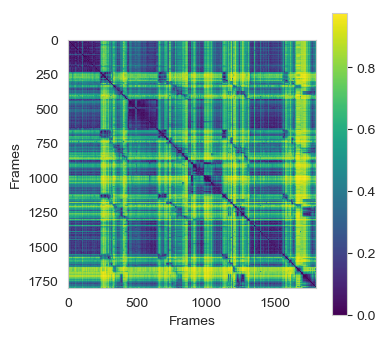

In [1332]:
#Calculate the cosine distance between each time vector
trial_sim_dist = self_cosine_vectorized(trial_trace.values) #Cosine similarity as a distance (10Hz)

# plot cosine distance matrix
plt.figure(figsize=(4, 4), dpi=100)
plt.imshow(trial_sim_dist, cmap=cm.viridis)
plt.colorbar()
plt.xlabel('Frames')
plt.ylabel('Frames')
plt.grid(b=None)
plt.show()

In [1260]:
#MDS of cosine distance
trial_X_transformed1, evals = cmdscale(trial_sim_dist)

#Calculate explained variance per eval
pos_evals = [e for e in evals if e > 0]
sum_evals = np.sum(pos_evals)
var_exp = np.cumsum(pos_evals/sum_evals) #cumulative summation

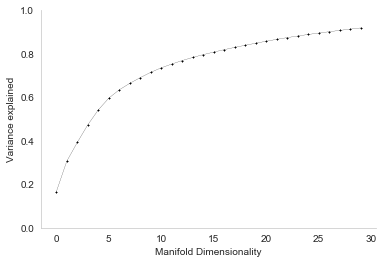

In [1334]:
#Plot fraction of explained variance in MDS
# fig = plt.figure(num=None, figsize=(4,2), dpi=50, facecolor='w', edgecolor='k')
plt.plot(np.arange(0,len(var_exp[:30]),1),var_exp[:30], marker='+', markersize=2,linewidth=0.2, c='k')
plt.xlabel('Manifold Dimensionality')
plt.ylabel('Variance explained')
sns.despine()
plt.ylim(0,1)
plt.grid(b=False)

In [1295]:
#Extract MDS coordinates for individual trials
trial_idxs = []
start_idx = 0
for t in range(len(trials)):
    if t in correct_trials:
        trial_idxs.append(np.arange(start_idx,start_idx+len(trials[t]),1))
        start_idx+=len(trials[t])

trial=1 #<------ Plot different All/individual trials

if trial == 'all':
    plot_trial = trial_X_transformed1
    trial_y = trial_behav_vec
    print(plot_trial.shape, trial_y.shape)
else:
    plot_trial = trial_X_transformed1[trial_idxs[trial]]
    # trial_y = np.array(all_info['position'])[trials[correct_trials[trial]]]
    trial_y =  new_behav_vec[trials[correct_trials[trial]]]
    print(plot_trial.shape, trial_y.shape)

(436, 106) (436,)


(-0.8, 0.3)

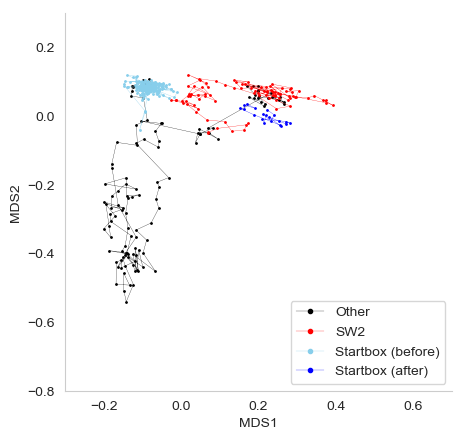

In [1296]:
#Plot MDS 2D
fig = plt.figure(num=None, figsize=(5, 5), dpi=100, facecolor='w', edgecolor='k')
colors = ['k','r','skyblue','b']
target_names = ['Other', 'SW2', 'Startbox (before)', 'Startbox (after)']
b_vec_labels = [0,2,9,12]

for color, i, target_name in zip(colors, b_vec_labels, target_names):
    plt.plot(plot_trial[trial_y == i, 0], plot_trial[trial_y == i, 1], 
                color=color, label=target_name, marker='o', markersize=1, linewidth=0.2)
    
plt.legend(target_names, markerscale=3)
plt.xlabel('MDS1')
plt.ylabel('MDS2')
sns.despine()
plt.grid(b=None)
plt.xlim(-0.3,0.7)
plt.ylim(-0.8,0.3)


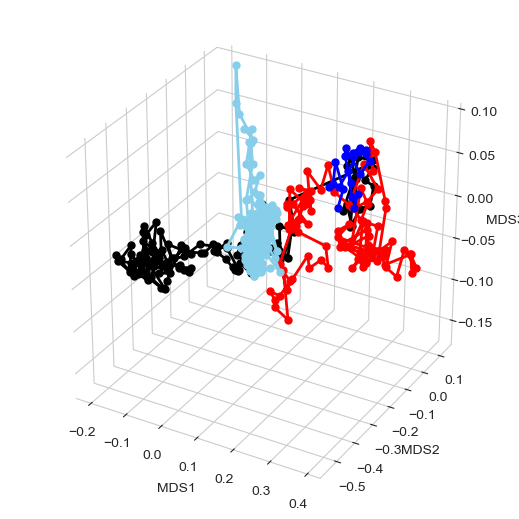

In [1301]:
#Plot MDS 3D
fig = plt.figure(num=None, figsize=(5, 5), dpi=100, facecolor='w', edgecolor='k')
ax = Axes3D(fig)
sns.set_style('whitegrid')

# Get rid of colored axes planes
# First remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')


ax.set_xlabel('MDS%d' %int(0+1), fontsize=10)
ax.set_ylabel('MDS%d' %int(1+1), fontsize=10)
ax.set_zlabel('MDS%d' %int(2+1), fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=10)

for color, i, target_name in zip(colors,b_vec_labels, target_names):
    ax.plot(plot_trial[trial_y == i, 0], plot_trial[trial_y == i, 1],plot_trial[trial_y == i, 2],
            color=color, label=target_name, marker='o', markersize=5, linewidth=2)

# plt.axis('off')
plt.show()

### Seperate analysis - When does the population encode reward

The analysis below visualises all cell activity occuring whilst the animal is in a reward location

[]

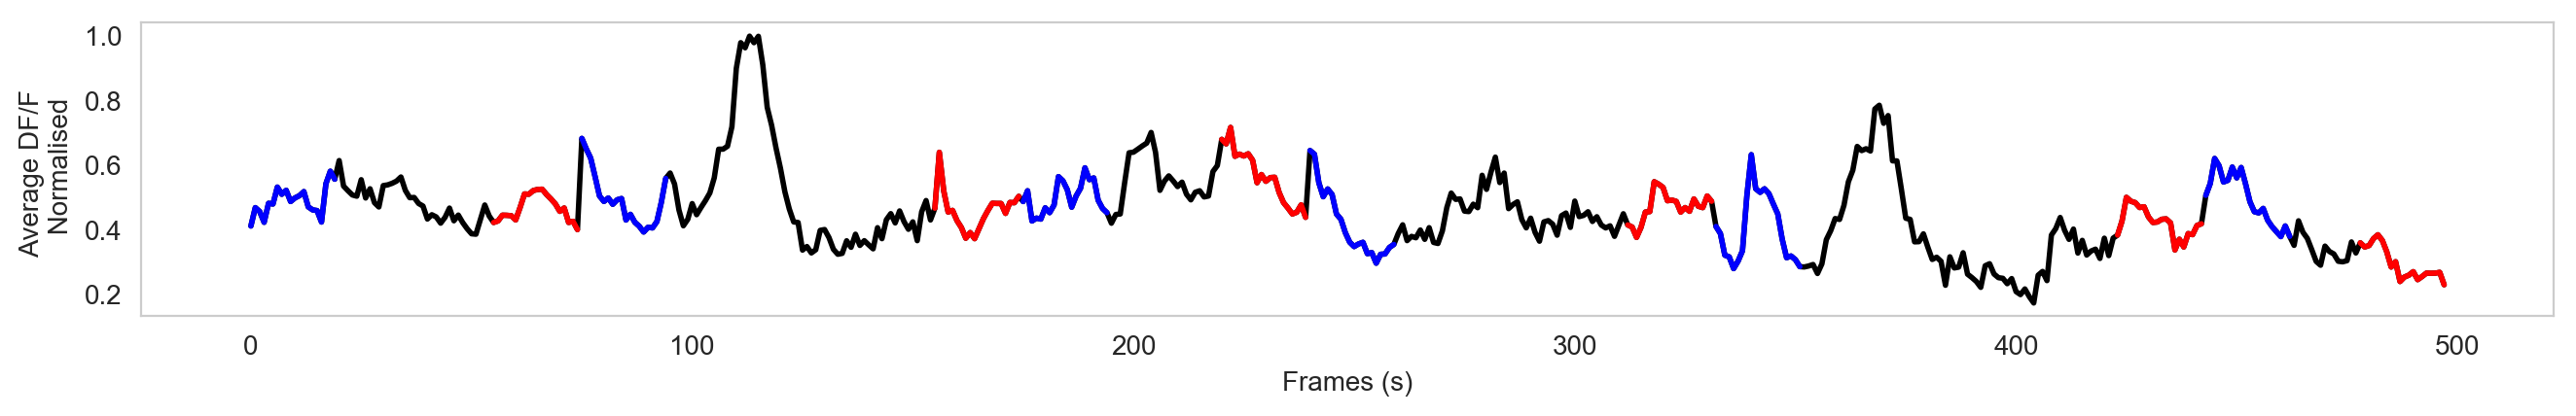

In [1311]:
#Extract activity for rw during each trial
rw = int(np.array(all_info['well'])[0][-1]) #reward location        
start_dur = 20 # Begining of trial rw loc
end_dur = 20 # Begining of trial rw loc
         
rw_idxs = []; rw_start = []; rw_end = []; start_idx = 0
for t in trials:
    t_vec = new_behav_vec[t] # trial_vector
    trial_rw_idxs = [t[i] for i in range(len(t_vec)) if t_vec[i] == rw] # rw indexes
    rw_idxs.append(trial_rw_idxs)
    
    #Define start and end rw_indexes
    rw_start.append(np.arange(0+start_idx,start_idx+start_dur,1))
    rw_end.append(np.arange(start_idx+len(trial_rw_idxs)-end_dur, start_idx+len(trial_rw_idxs),1))
    start_idx+=len(trial_rw_idxs)
rw_idxs = [item for sublist in rw_idxs for item in sublist]

rw_traces_df = traces_df.loc[rw_idxs] #Extract activity during rw locations
rw_traces_df = rw_traces_df.reset_index(drop=True)
rw_traces_df['avg'] = rw_traces_df.mean(axis=1) #Average across columns
rw_traces_df = rw_traces_df.apply(lambda x: x/x.max(), axis=0) # normalize each cell by its max 

fig = plt.figure(num=None, figsize=(16, 2), dpi=200, facecolor='w', edgecolor='k')
plt.plot(rw_traces_df['avg'].astype(float), c='k', linewidth=2)
for start, end in zip(rw_start, rw_end):
    plt.plot(rw_traces_df['avg'].loc[start].astype(float), c='b', linewidth=2)
    plt.plot(rw_traces_df['avg'].loc[end].astype(float), c='r', linewidth=2)    
plt.grid()
plt.xlabel('Frames (s)')
plt.ylabel('Average DF/F \n Normalised')
plt.plot()

In [1335]:
# #Visualise all cell traces as final check
# from itertools import cycle
# cycol = cycle('bgrcmk')

# columns = 1
# rows = len(cells)
# fig, ax_array = plt.subplots(rows, columns, figsize=(100, 100), squeeze=False)
# for i,ax_row in enumerate(ax_array):
#     for j,axes in enumerate(ax_row):
#         axes.set_facecolor('xkcd:white')
#         axes.plot(rw_traces_df[cells[i]].astype(float), c='k', linewidth=5)
#         for start, end in zip(rw_start, rw_end):
#             axes.plot(rw_traces_df.loc[start][cells[i]].astype(float), c='b', linewidth=5)
#             axes.plot(rw_traces_df.loc[end][cells[i]].astype(float), c='r', linewidth=5)
#         axes.get_yaxis().set_ticks([])
#         axes.get_xaxis().set_visible(False)
#         axes.axis('off')